In [1]:
import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
%matplotlib inline

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)

In [2]:
%store -r

In [3]:
#%store

In [4]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

tile_map = [
        "F22222FF1",
        "U31122FU1",
        "UF1112FU1",
        "UFUU1SFU1",
        "UFFU1FFU3",
        "3222UFS1U",
        "UUU22F1FU",
        "FSSFS12SF",
        "FSFF121FF",
        "S1S2SFFSF",
        "FUUUFFSFU",
        "U3UUUFSFU",
        "FFFUUFUUU"
    ]

# tile_map = [
#         "3FFFFFFF1",
#         "FFFFFFFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUU3UUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':4.0,
              'S':0.0,
              'U':0.0}

tile_reward_modifier = lambda r,x,y,mx,my: r * 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.0,0.0,0.0,1.0)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.98

alpha = 0.0001

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [5]:
# reward_normalizer = (1-gamma)/(np.max(reward_map))
# reward_map *= reward_normalizer
# time_penalty *= reward_normalizer

In [6]:
# temperature = 1/(reward_normalizer)
# print(temperature)

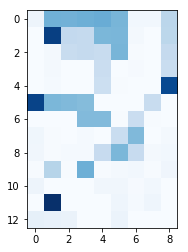

In [7]:
plt.imshow(reward_map, cmap="Blues")

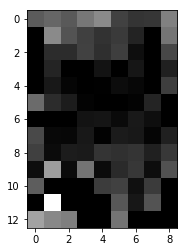

In [8]:
plt.imshow(texture_map, cmap="gray")

In [9]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [10]:
print(mdp.tile_map.flatten()[43])

b'U'


In [11]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning

In [12]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [13]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = alpha * logsumexp(prevQ / alpha, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = np.sum(T * (R + gamma * V_broad), axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [14]:
def tabsoftq_learn_Qs(mdp):
    R = mdp.rewards
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [15]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [16]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


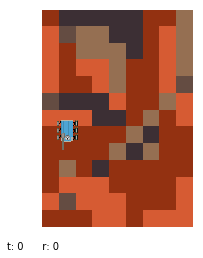

[131.54263538 145.90260659 132.0080954   29.30611569 143.00395386]
1
[0.00000055 0.94777845 0.00000088 0.         0.05222013]
(1, 7) b'S'
(1, 8) b'S'


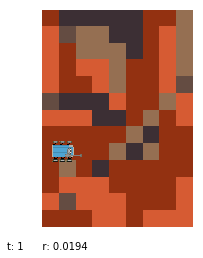

[148.35089682 145.42602104 148.70031927 144.35076567 145.75349986]
2
[0.38990916 0.02092695 0.55298796 0.0071405  0.02903543]
(1, 8) b'S'
(1, 7) b'S'


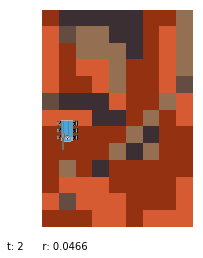

[131.54263538 145.90260659 132.0080954   29.30611569 143.00395386]
1
[0.00000055 0.94777845 0.00000088 0.         0.05222013]
(1, 7) b'S'
(1, 8) b'S'


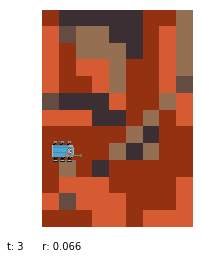

[148.35089682 145.42602104 148.70031927 144.35076567 145.75349986]
2
[0.38990916 0.02092695 0.55298796 0.0071405  0.02903543]
(1, 8) b'S'
(2, 8) b'F'


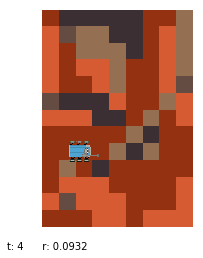

[145.95454529 147.40680838 152.94736138 147.45675877 149.95640198]
2
[0.00086712 0.00370499 0.94410218 0.00389476 0.04743095]
(2, 8) b'F'
(3, 8) b'F'


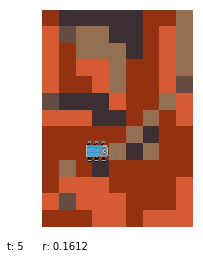

[150.76114881 153.19575198 157.58363186 154.86064743 154.49451998]
2
[0.00096824 0.01104885 0.88909682 0.0583945  0.04049159]
(3, 8) b'F'
(3, 7) b'F'


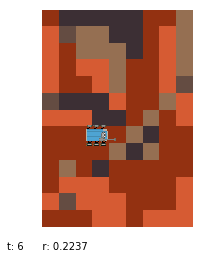

[148.39736264 154.16950735 158.12457996 154.70152225 155.02069582]
2
[0.00005438 0.01746805 0.91182303 0.02973689 0.04091766]
(3, 7) b'F'
(4, 7) b'S'


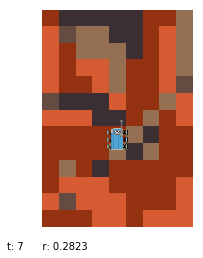

[155.66850495 158.60659936 162.18734954 158.24697645 158.94896762]
3
[0.00135604 0.02560187 0.91911896 0.01786856 0.03605457]
(4, 7) b'S'
(4, 6) b'2'


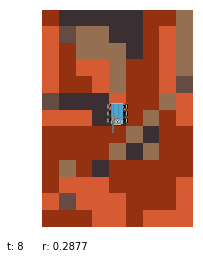

[140.02331628 159.16700785 147.8307245   32.01414275 158.03497714]
1
[0.         0.75620664 0.00000902 0.         0.24378434]
(4, 6) b'2'
(4, 7) b'S'


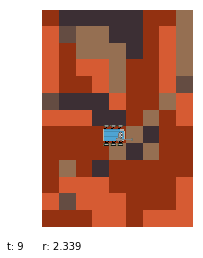

[155.66850495 158.60659936 162.18734954 158.24697645 158.94896762]
2
[0.00135604 0.02560187 0.91911896 0.01786856 0.03605457]
(4, 7) b'S'
(5, 7) b'1'


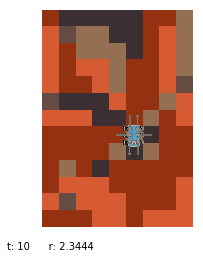

[159.80198824 161.69847581 165.41165418 164.42604088 163.16925155]
4
[0.00242942 0.0161859  0.66336072 0.24757303 0.07045092]
(5, 7) b'1'
(5, 7) b'1'


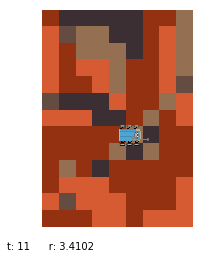

[159.80198824 161.69847581 165.41165418 164.42604088 163.16925155]
2
[0.00242942 0.0161859  0.66336072 0.24757303 0.07045092]
(5, 7) b'1'
(5, 6) b'F'


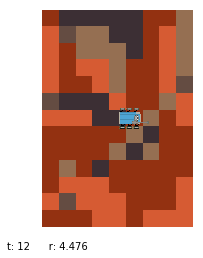

[159.69614342 163.18481807 168.0355146  168.25930919 164.91879889]
2
[0.00010374 0.00339658 0.43418262 0.54308172 0.01923535]
(5, 6) b'F'
(6, 6) b'1'


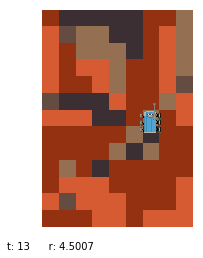

[165.78567137 165.54805827 164.14933905 170.8154362  168.45919112]
3
[0.00590419 0.0046555  0.0011495  0.90273381 0.08555699]
(6, 6) b'1'
(6, 5) b'S'


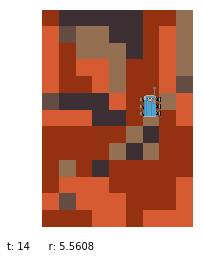

[170.44025602 166.95096854 156.68939644 176.05917206 172.54527245]
3
[0.00351089 0.00010716 0.         0.96756726 0.02881469]
(6, 5) b'S'
(5, 5) b'F'


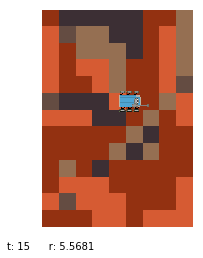

[ 34.94026102 149.19035499 172.97016998 164.79189291 169.51236545]
2
[0.         0.         0.96919931 0.00027204 0.03052865]
(5, 5) b'F'
(6, 5) b'S'


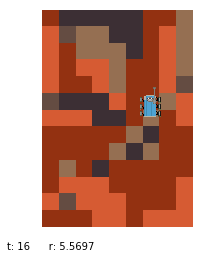

[170.44025602 166.95096854 156.68939644 176.05917206 172.54527245]
3
[0.00351089 0.00010716 0.         0.96756726 0.02881469]
(6, 5) b'S'
(6, 4) b'F'


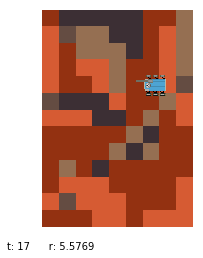

[183.49693112 156.47907872  35.96666308 168.08947545 179.84444553]
0
[0.9747284 0.        0.        0.0000002 0.0252714]
(6, 4) b'F'
(5, 4) b'F'


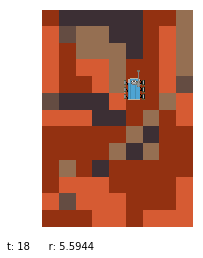

[168.97286901 170.19754933 180.02272609 188.15512194 184.42072129]
3
[0.         0.00000002 0.00028693 0.97638957 0.02332349]
(5, 4) b'F'
(5, 3) b'S'


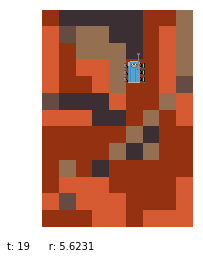

[188.19824606 184.98650966 187.89201444 195.87655356 191.95933122]
3
[0.00045336 0.00001826 0.00033377 0.97970217 0.01949243]
(5, 3) b'S'
(5, 2) b'2'


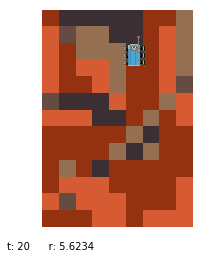

[199.49023544 192.8647314  193.42621326 199.88307056 198.03327617]
3
[0.36794888 0.00048794 0.00085549 0.54499638 0.08571131]
(5, 2) b'2'
(5, 1) b'2'


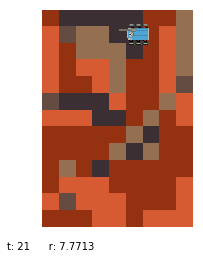

[202.64534296 198.27338164 195.24653382 197.89130437 200.73225516]
0
[0.85508154 0.01079665 0.00052329 0.00736809 0.12623043]
(5, 1) b'2'
(5, 2) b'2'


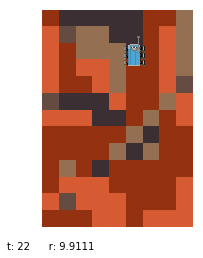

[199.49023544 192.8647314  193.42621326 199.88307056 198.03327617]
3
[0.36794888 0.00048794 0.00085549 0.54499638 0.08571131]
(5, 2) b'2'
(5, 1) b'2'


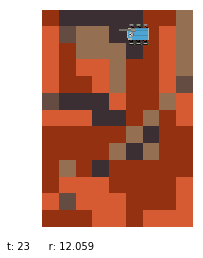

[202.64534296 198.27338164 195.24653382 197.89130437 200.73225516]
0
[0.85508154 0.01079665 0.00052329 0.00736809 0.12623043]
(5, 1) b'2'
(5, 0) b'2'


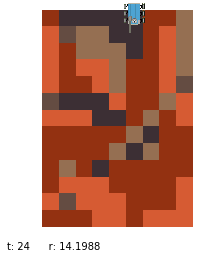

[196.86517571 199.38474835 184.70552685 162.92973529 197.55567959]
1
[0.06485921 0.80576448 0.00000034 0.         0.12937598]
(5, 0) b'2'
(5, 1) b'2'


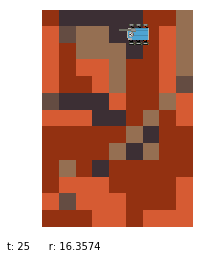

[202.64534296 198.27338164 195.24653382 197.89130437 200.73225516]
0
[0.85508154 0.01079665 0.00052329 0.00736809 0.12623043]
(5, 1) b'2'
(4, 1) b'2'


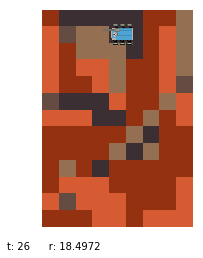

[205.85578063 201.0028893  200.77288889 202.05741381 203.85805923]
0
[0.85319932 0.00665988 0.0052915  0.01911792 0.11573138]
(4, 1) b'2'
(4, 0) b'2'


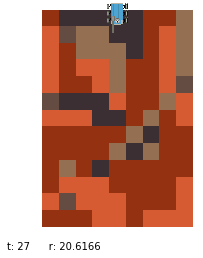

[184.29003347 203.32994521 178.43113822  40.24980682 201.59450164]
1
[0.         0.85010738 0.         0.         0.14989261]
(4, 0) b'2'
(5, 0) b'2'


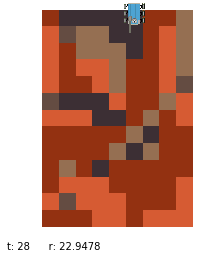

[196.86517571 199.38474835 184.70552685 162.92973529 197.55567959]
1
[0.06485921 0.80576448 0.00000034 0.         0.12937598]
(5, 0) b'2'
(5, 1) b'2'


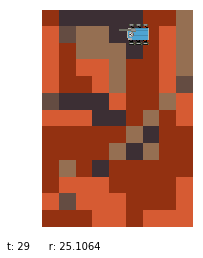

[202.64534296 198.27338164 195.24653382 197.89130437 200.73225516]
0
[0.85508154 0.01079665 0.00052329 0.00736809 0.12623043]
(5, 1) b'2'
(4, 1) b'2'


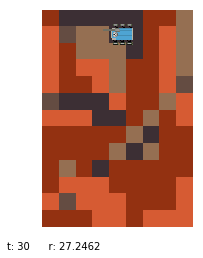

[205.85578063 201.0028893  200.77288889 202.05741381 203.85805923]
0
[0.85319932 0.00665988 0.0052915  0.01911792 0.11573138]
(4, 1) b'2'
(3, 1) b'1'


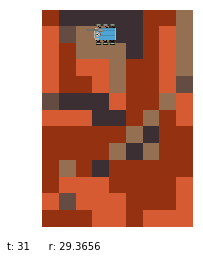

[210.13445323 204.2445043  203.91125128 205.45295101 207.08586983]
0
[0.94211535 0.00260694 0.00186811 0.00872878 0.04468082]
(3, 1) b'1'
(2, 1) b'1'


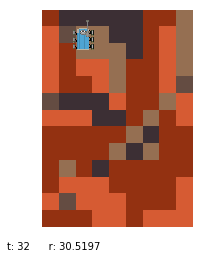

[214.73268576 207.47904331 207.21013628 209.56746528 211.63706168]
3
[0.95038341 0.00067248 0.00051392 0.0054284  0.04300178]
(2, 1) b'1'
(2, 0) b'2'


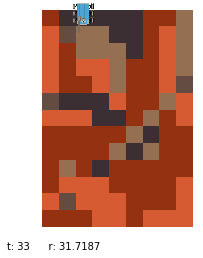

[210.12540462 211.01679824 204.27509126 195.37071826 209.01246579]
1
[0.26525221 0.64682431 0.00076366 0.0000001  0.08715972]
(2, 0) b'2'
(2, 1) b'1'


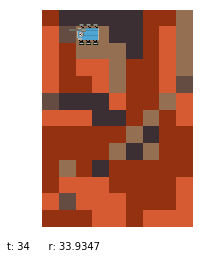

[214.73268576 207.47904331 207.21013628 209.56746528 211.63706168]
0
[0.95038341 0.00067248 0.00051392 0.0054284  0.04300178]
(2, 1) b'1'
(1, 1) b'3'


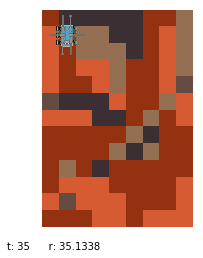

[ 41.06468405 179.87774291 210.36802439 190.91824707 216.48905668]
4
[0.         0.         0.00219138 0.         0.99780862]
(1, 1) b'3'
(1, 1) b'3'


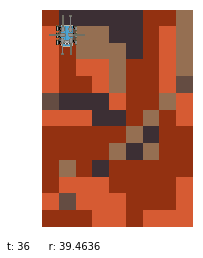

[ 41.06468405 179.87774291 210.36802439 190.91824707 216.48905668]
4
[0.         0.         0.00219138 0.         0.99780862]
(1, 1) b'3'
(1, 1) b'3'


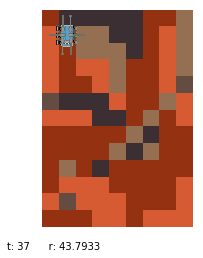

[ 41.06468405 179.87774291 210.36802439 190.91824707 216.48905668]
4
[0.         0.         0.00219138 0.         0.99780862]
(1, 1) b'3'
(1, 1) b'3'


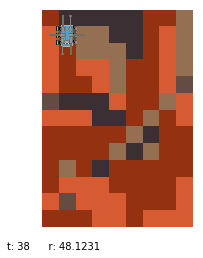

[ 41.06468405 179.87774291 210.36802439 190.91824707 216.48905668]
4
[0.         0.         0.00219138 0.         0.99780862]
(1, 1) b'3'
(1, 1) b'3'


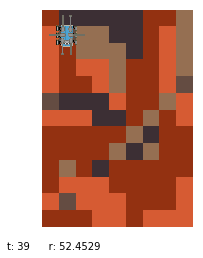

[ 41.06468405 179.87774291 210.36802439 190.91824707 216.48905668]
4
[0.         0.         0.00219138 0.         0.99780862]
(1, 1) b'3'
(1, 1) b'3'


In [17]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q),Qs=Q)


In [18]:
print(mdp.feature_map)

[[0.21823344 0.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.12651056 0.         0.         0.        ]
 [0.13102418 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.0845164  0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.1050801  0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         

# Inverse Dynamics Learning

In [19]:
def transition_grad(adt, tps):
    a,d,t = adt
    grad_theta_t = np.zeros(tps.shape)
    grad_theta_t[a,d,t] += 1
    grad_theta_t[a,:,t] -= tps[a,:,t]
    return grad_theta_t


In [20]:
def tabsoftq_T_grad_iter(T_thetas, Q, R, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_theta = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_theta = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_theta = R_theta + gamma * V_theta 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_theta)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
    G = T_grad if G_init is None else G_init
    T_broad = T.reshape((nS, nA, nS, 1))
    prevG = copy(G)
    if verbose:
        diffs = []
    for iter_idx in range(maxiter):
        expG = np.sum(P_broad * G, axis=1)
        expG_broad = expG.reshape((1, 1, nS, T_theta_dim))
        G = gamma * T_grad
        t_expG = np.sum(T_broad * expG_broad, axis=2)
        G += gamma * t_expG
        G = (1 - learning_rate) * prevG + learning_rate * G
    
        diff = np.mean((G - prevG)**2)/(np.std(G)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevG = copy(G)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
    expG = np.sum(P_broad * G, axis=1)
    expG_broad = expG.reshape((nS, 1, T_theta_dim))
    return (G - expG_broad)

In [21]:
def eval_pol_likelihood(Q, sas_obs, verbose=False):
    ll = 0.0
    for obs in sas_obs:
        s,a,sprime = obs
        l = np.log(softmax(Q[s])[a])
        ll += l
    return ll

def eval_trans_likelihood(Tps, adt_obs, verbose=False):
    ll = 0.0
    for obs in adt_obs:
        a,d,t, = obs
        l = np.log(Tps[a,d,t])
        ll += l
    return ll

def eval_trans_likelihood_and_grad(T_thetas, adt_obs):
    Tps = softmax(T_thetas,axis=1)
    dT = sum([transition_grad(adt,Tps) for adt in adt_obs]).reshape(T_thetas.shape) / len(adt_obs)
    ll = eval_trans_likelihood(Tps, adt_obs)
    return ll, dT

def eval_demo_log_likelihood(sas_obs, adt_obs, T_thetas, Q):
    Tps = softmax(T_thetas,axis=1)
    p_ll = eval_pol_likelihood(Q, sas_obs)
    t_ll = eval_trans_likelihood(Tps, adt_obs)
    return p_ll, t_ll
        

In [22]:
def eval_T_pol_likelihood_and_grad(T_thetas, R, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits if Q_inits is not None else None, 
        maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    dT = tabsoftq_T_grad_iter(T_thetas, Q, R, T=T, maxiter=tabsoftq_grad_iter_maxiter,
        verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    # Sum instead of mean because sparse results
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, Q


# Simultaneous Estimation of Rewards and Dynamics

In [23]:
def tabsoftq_TR_grad_iter(T_thetas, feat_map, R,  Q, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    R_theta_dim = feat_map.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    
    R_grad = T.dot(feat_map)
    
    GR = np.zeros((nS, nA, R_theta_dim)) if G_init is None else G_init[0]
    prevGR = copy(GR)
    
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_t = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_t = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_t = R_t + gamma * V_t 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_t)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
              
    GT = T_grad if G_init is None else G_init[1]
    T_broad = T.reshape((nS, nA, nS, 1))
    prevGT = copy(GT)
    
    if verbose:
        diffs = []
        
    for iter_idx in range(maxiter):
        # Reward Param gradient iteration
        expGR = np.sum(P_broad * GR, axis=1)
        expGR_broad = expGR.reshape((1, 1, nS, R_theta_dim))
        GR = R_grad + gamma * np.sum(T_broad * expGR_broad, axis=2)
        GR = (1 - learning_rate) * prevGR + learning_rate * GR
        
        
        # Transition Param grad iter
        expGT = np.sum(P_broad * GT, axis=1)
        expGT_broad = expGT.reshape((1, 1, nS, T_theta_dim))
        GT = gamma * T_grad
        t_expGT = np.sum(T_broad * expGT_broad, axis=2)
        GT += gamma * t_expGT
        GT = (1 - learning_rate) * prevGT + learning_rate * GT
    
        diff = np.mean((GR - prevGR)**2)/(np.std(GR)**2) + np.mean((GT - prevGT)**2)/(np.std(GT)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevGR = copy(GR)
        prevGT = copy(GT)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
  
    expGR = np.sum(P_broad * GR, axis=1)
    expGR_broad = expGR.reshape((nS, 1, R_theta_dim))
    expGT = np.sum(P_broad * GT, axis=1)
    expGT_broad = expGT.reshape((nS, 1, T_theta_dim))
    return (GR - expGR_broad), (GT - expGT_broad)

In [24]:
def eval_TR_pol_likelihood_and_grad(T_thetas, R, feat_map, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits if Q_inits is not None else None, 
        maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    dR, dT = tabsoftq_TR_grad_iter(T_thetas, feat_map, R, Q, T=T,
        maxiter=tabsoftq_grad_iter_maxiter, verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dR = np.sum(dR[s,a], axis=0).reshape(feat_map.shape[1]) / len(sas_obs)
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, dR, Q

# IDL & SERD Experiments

In [25]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 80
demo_time_steps = 40

In [26]:
def clean_demos(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays = set([])
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            if sas in unique_stays:
                demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
    return demo_example_idxes

def sample_batch(size, ids, sas_obs, adt_obs):
    idxes = random.sample(ids, size)
    return sas_obs[idxes], adt_obs[idxes]

In [27]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)/mdp.nA

In [28]:
exQs = tabsoftq_learn_Qs(mdp)
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

In [29]:
# Ensure bad areas have not been visited in exes
while len(set([adt[2] for adt in adt_obs])) > 1:
    demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
    sas_obs, adt_obs = vectorize_rollouts(demos)

In [30]:
# Clean training set to have greater density of interesting transitions
# print(len(sas_obs))
# demo_example_idxes = clean_demos(sas_obs)
# print(len(demo_example_idxes))
demo_example_idxes = list(range(len(sas_obs)))


In [31]:
random.shuffle(demo_example_idxes)
n_train_demo_examples = int(0.9 * len(demo_example_idxes))
train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
val_sas_obs = sas_obs[val_demo_example_idxes]
val_adt_obs = adt_obs[val_demo_example_idxes]

## IDL Only

In [32]:
idl_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [33]:
maxiter = 500
learning_rate = 1

In [34]:
Ti_thetas = T_estimate(adt_obs[train_demo_example_idxes])
Qi, Ri = None, mdp.rewards

In [35]:
while len(idl_train_logs['tt_lls']) < maxiter:
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    #Should we initialize Qs or nah?
    tp_ll, dT_pol, Qi = eval_T_pol_likelihood_and_grad(Ti_thetas, Ri, batch_demo_sas, Q_inits=Qi)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ti_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ti_thetas, Qi)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ti_thetas))
    Ti_thetas += learning_rate * (dT_trans + dT_pol)
    
    print('%d %f %f %f %f' % (len(idl_train_logs['tt_lls']), vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    idl_train_logs['train_likelihoods'].append(train_likelihood)
    idl_train_logs['val_likelihoods'].append(val_likelihood)
    idl_train_logs['tp_lls'].append(tp_ll)
    idl_train_logs['tt_lls'].append(tt_ll)
    idl_train_logs['vp_lls'].append(vp_ll)
    idl_train_logs['vt_lls'].append(vt_ll)
    idl_train_logs['true_trans_loss'].append(ttd)

0 -474.681785 -98.882925 -573.564710 2.231689
1 -467.516951 -98.715686 -566.232637 2.228337
2 -458.473207 -98.409346 -556.882552 2.224633
3 -438.680660 -97.928205 -536.608865 2.222431
4 -427.660972 -98.197801 -525.858774 2.225469
5 -419.793445 -98.403863 -518.197309 2.224580
6 -420.423640 -98.721098 -519.144738 2.223929
7 -414.887270 -99.014877 -513.902147 2.226336
8 -405.518479 -99.533750 -505.052229 2.236636
9 -399.509389 -99.915085 -499.424474 2.240597
10 -396.664486 -101.184236 -497.848722 2.252808
11 -385.875804 -101.583021 -487.458824 2.269097
12 -381.183871 -102.097861 -483.281732 2.281286
13 -377.328076 -102.918386 -480.246462 2.292794
14 -358.567032 -103.789719 -462.356751 2.309692
15 -341.639770 -104.950340 -446.590111 2.338827
16 -316.020626 -105.983311 -422.003937 2.362802
17 -277.601314 -108.542371 -386.143685 2.395433
18 -268.759316 -109.064815 -377.824131 2.410665
19 -257.973423 -110.411420 -368.384842 2.423545
20 -247.623884 -111.607601 -359.231485 2.450378
21 -244.0443

170 -93.359576 -107.581187 -200.940763 0.791524
171 -93.884052 -106.144335 -200.028387 0.760995
172 -93.753545 -105.994448 -199.747993 0.758707
173 -93.427759 -105.424656 -198.852415 0.760369
174 -92.544639 -106.077662 -198.622301 0.755290
175 -92.458769 -106.539232 -198.998001 0.761114
176 -92.247067 -106.015980 -198.263048 0.743436
177 -92.653564 -105.870644 -198.524207 0.737364
178 -90.899367 -106.874043 -197.773410 0.746083
179 -90.848843 -106.588523 -197.437366 0.726479
180 -90.661759 -106.751369 -197.413128 0.730706
181 -91.616131 -105.928880 -197.545010 0.714482
182 -92.629277 -104.329483 -196.958760 0.673547
183 -91.508802 -105.073274 -196.582076 0.656372
184 -90.728407 -105.501923 -196.230330 0.651279
185 -90.791455 -105.775811 -196.567265 0.659373
186 -91.332145 -105.253565 -196.585710 0.657350
187 -91.780356 -105.923130 -197.703487 0.644817
188 -92.364888 -104.915293 -197.280180 0.618914
189 -91.196562 -104.985579 -196.182141 0.603924
190 -90.950898 -104.831237 -195.782135 0

341 -87.186632 -101.620065 -188.806697 0.252846
342 -85.338888 -102.248374 -187.587262 0.245431
343 -86.006034 -101.697025 -187.703059 0.238682
344 -85.970555 -101.579796 -187.550351 0.233998
345 -85.165177 -101.638289 -186.803466 0.224507
346 -85.599808 -101.621595 -187.221403 0.227038
347 -85.355052 -101.091915 -186.446967 0.216522
348 -84.673696 -101.079322 -185.753019 0.219948
349 -85.155477 -100.855013 -186.010490 0.206205
350 -83.483561 -102.066605 -185.550166 0.231945
351 -84.434968 -101.555385 -185.990353 0.222151
352 -84.292863 -101.486297 -185.779160 0.218176
353 -85.013986 -101.225172 -186.239159 0.226459
354 -84.134151 -101.824179 -185.958330 0.233619
355 -85.304455 -101.893480 -187.197935 0.228402
356 -86.392022 -101.192616 -187.584638 0.208280
357 -85.960392 -100.725505 -186.685896 0.203151
358 -86.082971 -100.313802 -186.396773 0.202225
359 -85.248891 -101.110319 -186.359210 0.202339
360 -84.836593 -101.595153 -186.431746 0.206883
361 -84.442963 -101.835774 -186.278737 0

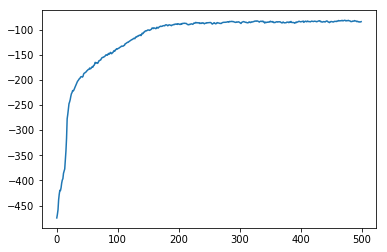

In [36]:
plt.plot(idl_train_logs['vp_lls'])

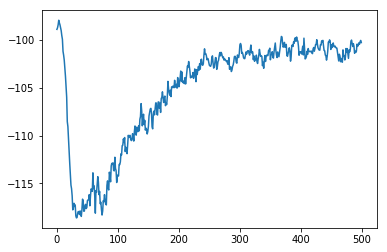

In [37]:
plt.plot(idl_train_logs['vt_lls'])

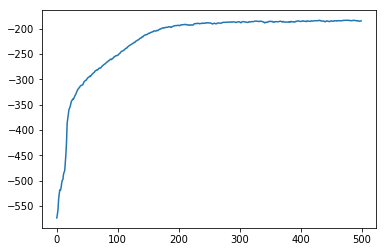

In [38]:
plt.plot(idl_train_logs['val_likelihoods'])

In [39]:
print(Qi[[s for s in range(nS) if mdp.get_tile_type(s)==1]])

[[ 94.62451393  94.62451393  94.62451393  94.62451393  94.62451393]
 [ 91.34930156  91.34930156  91.34930156  91.34930156  91.34930156]
 [ 83.82751808  83.82751808  83.82751808  83.82751808  83.82751808]
 [ 85.34500922  85.34500922  85.34500922  85.34500922  85.34500922]
 [ 86.7389781   86.7389781   86.7389781   86.7389781   86.7389781 ]
 [ 91.4944909   91.4944909   91.4944909   91.4944909   91.4944909 ]
 [ 77.92708716  77.92708716  77.92708716  77.92708716  77.92708716]
 [ 88.07702229  88.07702229  88.07702229  88.07702229  88.07702229]
 [107.75322823 107.75322823 107.75322823 107.75322823 107.75322823]
 [ 89.43852538  89.43852538  89.43852538  89.43852538  89.43852538]
 [ 99.20427027  99.20427027  99.20427027  99.20427027  99.20427027]
 [ 98.1739262   98.1739262   98.1739262   98.1739262   98.1739262 ]
 [ 95.92527734  95.92527734  95.92527734  95.92527734  95.92527734]
 [ 65.45850731  65.45850731  65.45850731  65.45850731  65.45850731]
 [ 62.17308575  62.17308575  62.17308575  62.173

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


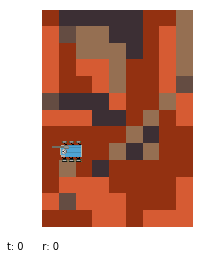

(1, 8) b'S'
(0, 8) b'F'


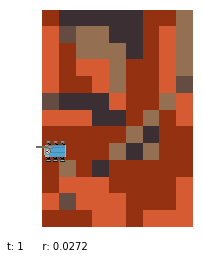

(0, 8) b'F'
(8, 8) b'F'


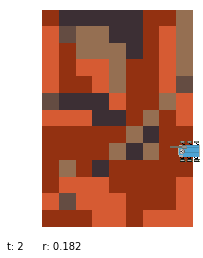

(8, 8) b'F'
(7, 8) b'F'


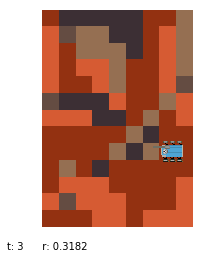

(7, 8) b'F'
(6, 8) b'1'


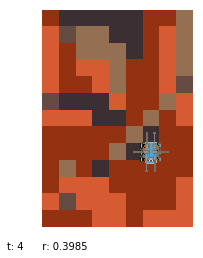

(6, 8) b'1'
(6, 8) b'1'


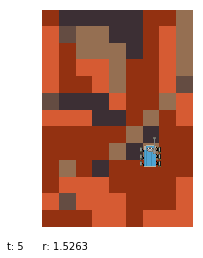

(6, 8) b'1'
(6, 7) b'2'


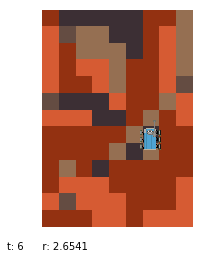

(6, 7) b'2'
(6, 6) b'1'


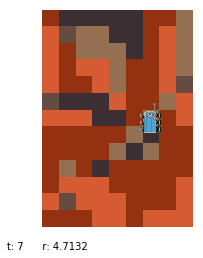

(6, 6) b'1'
(5, 6) b'F'


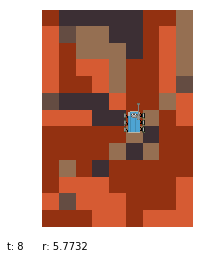

(5, 6) b'F'
(4, 6) b'2'


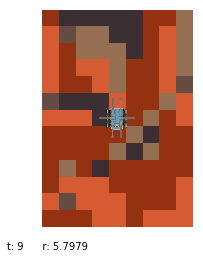

(4, 6) b'2'
(4, 6) b'2'


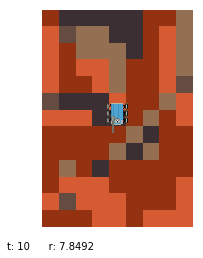

(4, 6) b'2'
(4, 7) b'S'


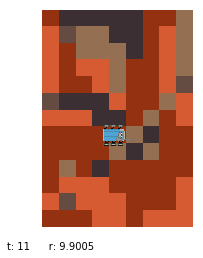

(4, 7) b'S'
(5, 7) b'1'


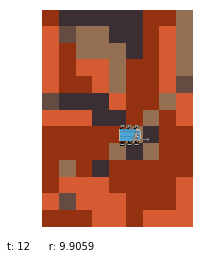

(5, 7) b'1'
(6, 7) b'2'


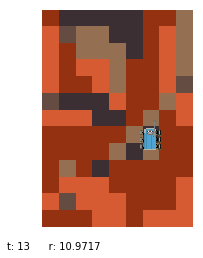

(6, 7) b'2'
(6, 6) b'1'


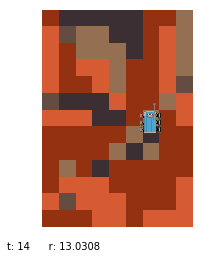

(6, 6) b'1'
(6, 5) b'S'


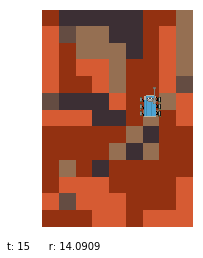

(6, 5) b'S'
(6, 4) b'F'


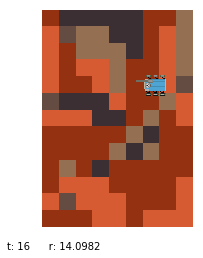

(6, 4) b'F'
(6, 3) b'F'


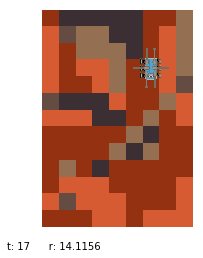

(6, 3) b'F'
(6, 3) b'F'


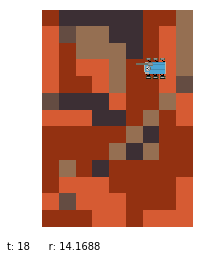

(6, 3) b'F'
(5, 3) b'S'


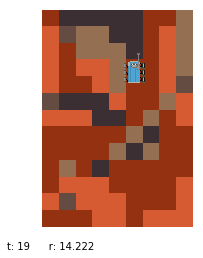

(5, 3) b'S'
(5, 2) b'2'


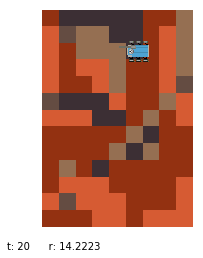

(5, 2) b'2'
(4, 2) b'1'


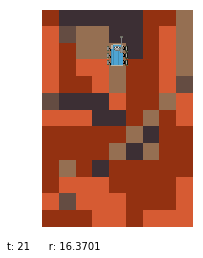

(4, 2) b'1'
(4, 1) b'2'


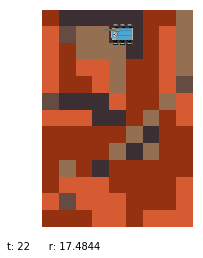

(4, 1) b'2'
(3, 1) b'1'


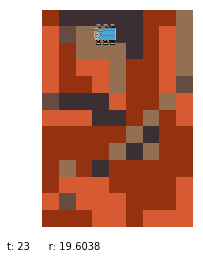

(3, 1) b'1'
(3, 0) b'2'


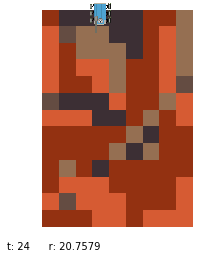

(3, 0) b'2'
(3, 1) b'1'


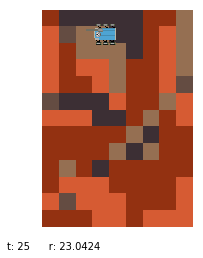

(3, 1) b'1'
(2, 1) b'1'


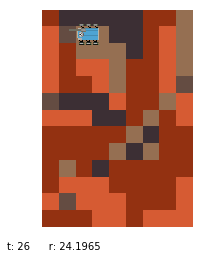

(2, 1) b'1'
(2, 2) b'1'


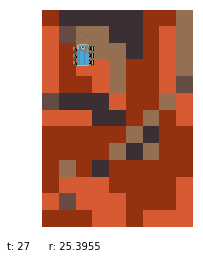

(2, 2) b'1'
(2, 1) b'1'


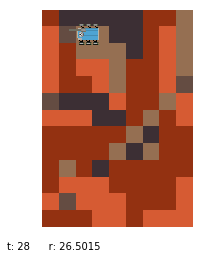

(2, 1) b'1'
(2, 0) b'2'


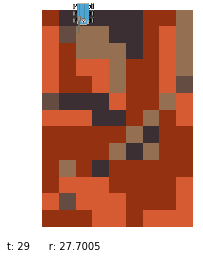

(2, 0) b'2'
(2, 1) b'1'


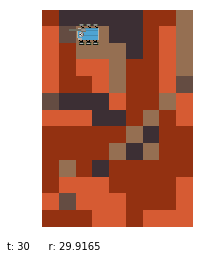

(2, 1) b'1'
(2, 2) b'1'


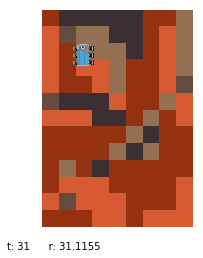

(2, 2) b'1'
(2, 1) b'1'


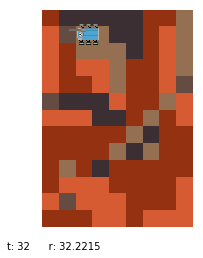

(2, 1) b'1'
(1, 1) b'3'


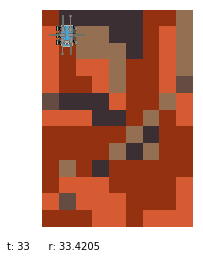

(1, 1) b'3'
(1, 1) b'3'


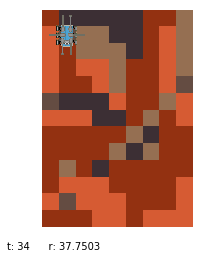

(1, 1) b'3'
(1, 1) b'3'


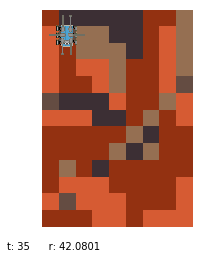

(1, 1) b'3'
(1, 1) b'3'


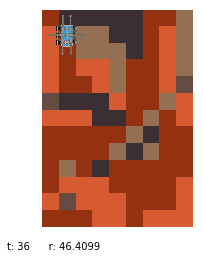

(1, 1) b'3'
(1, 1) b'3'


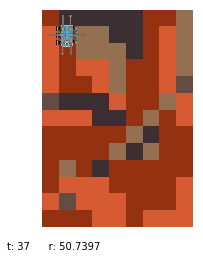

(1, 1) b'3'
(1, 1) b'3'


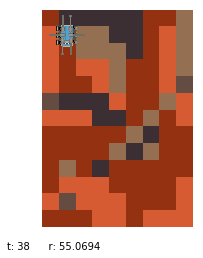

(1, 1) b'3'
(1, 1) b'3'


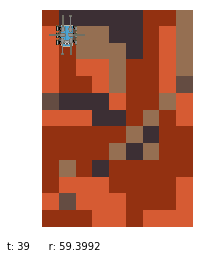

(1, 1) b'3'
(1, 1) b'3'
[[[0.78120028 0.01072298]
  [0.09304262 0.00636174]
  [0.00000002 0.00667491]
  [0.12575706 0.0047106 ]
  [0.00000002 0.97152977]]

 [[0.09203362 0.01072298]
  [0.79772224 0.00636174]
  [0.11024387 0.00667491]
  [0.00000014 0.0047106 ]
  [0.00000014 0.97152977]]

 [[0.00000005 0.01072298]
  [0.1047761  0.00636174]
  [0.7582983  0.00667491]
  [0.13692549 0.0047106 ]
  [0.00000005 0.97152977]]

 [[0.10915996 0.01072298]
  [0.00000002 0.00636174]
  [0.09217547 0.00667491]
  [0.79866453 0.0047106 ]
  [0.00000002 0.97152977]]

 [[0.00000001 0.01072298]
  [0.00000001 0.00636174]
  [0.00000001 0.00667491]
  [0.00000001 0.0047106 ]
  [0.99999997 0.97152977]]]


In [40]:
plot_mars(mdp,tabsoftq_gen_pol(Qi))
print(softmax(Ti_thetas))

In [41]:
tabsoftq_gen_pol_probs(Qi)[:,4]

array([0.02263561, 0.10001418, 0.07639462, 0.13673586, 0.15143626,
       0.12204118, 0.02479935, 0.04380132, 0.10316444, 0.2       ,
       0.99699512, 0.04295478, 0.04495571, 0.11685345, 0.12781814,
       0.02054057, 0.2       , 0.13888994, 0.2       , 0.01777348,
       0.04374195, 0.04914354, 0.03776421, 0.08054897, 0.02016939,
       0.2       , 0.11523223, 0.2       , 0.03025562, 0.2       ,
       0.2       , 0.05864197, 0.01963803, 0.02281299, 0.2       ,
       0.07065468, 0.2       , 0.02786918, 0.01848756, 0.2       ,
       0.04951978, 0.02311032, 0.02491208, 0.2       , 1.        ,
       1.        , 0.14660722, 0.18879969, 0.22642186, 0.2       ,
       0.01894839, 0.02790973, 0.10133031, 0.2       , 0.2       ,
       0.2       , 0.2       , 0.24244127, 0.2359456 , 0.01878342,
       0.08293222, 0.03458419, 0.2       , 0.05634803, 0.05186144,
       0.04768683, 0.03736357, 0.03505768, 0.06836737, 0.2038321 ,
       0.03236066, 0.04595752, 0.05124361, 0.02572414, 0.04689

In [42]:
print(softmax(Ti_thetas)) # - softmax(T_estimate(adt_obs[train_demo_example_idxes])))

[[[0.78120028 0.01072298]
  [0.09304262 0.00636174]
  [0.00000002 0.00667491]
  [0.12575706 0.0047106 ]
  [0.00000002 0.97152977]]

 [[0.09203362 0.01072298]
  [0.79772224 0.00636174]
  [0.11024387 0.00667491]
  [0.00000014 0.0047106 ]
  [0.00000014 0.97152977]]

 [[0.00000005 0.01072298]
  [0.1047761  0.00636174]
  [0.7582983  0.00667491]
  [0.13692549 0.0047106 ]
  [0.00000005 0.97152977]]

 [[0.10915996 0.01072298]
  [0.00000002 0.00636174]
  [0.09217547 0.00667491]
  [0.79866453 0.0047106 ]
  [0.00000002 0.97152977]]

 [[0.00000001 0.01072298]
  [0.00000001 0.00636174]
  [0.00000001 0.00667491]
  [0.00000001 0.0047106 ]
  [0.99999997 0.97152977]]]


In [43]:
test_T_likelihood(softmax(Ti_thetas), val_sas_obs, val_adt_obs)

[9, 16, 18, 25, 27, 29, 30, 34, 36, 39, 43, 49, 53, 54, 55, 56, 62, 91, 92, 93, 98, 99, 101, 102, 103, 107, 111, 112, 114, 115, 116]
[[ 94.45758905  94.45758905  94.45758905  94.45758905  94.45758905]
 [ 91.48100962  91.48100962  91.48100962  91.48100962  91.48100962]
 [ 83.82956231  83.82956231  83.82956231  83.82956231  83.82956231]
 [ 85.44323108  85.44323108  85.44323108  85.44323108  85.44323108]
 [ 86.75344447  86.75344447  86.75344447  86.75344447  86.75344447]
 [ 91.64782057  91.64782057  91.64782057  91.64782057  91.64782057]
 [ 78.04293971  78.04293971  78.04293971  78.04293971  78.04293971]
 [ 88.16140883  88.16140883  88.16140883  88.16140883  88.16140883]
 [107.82950737 107.82950737 107.82950737 107.82950737 107.82950737]
 [ 89.89805936  89.89805936  89.89805936  89.89805936  89.89805936]
 [ 99.33725966  99.33725966  99.33725966  99.33725966  99.33725966]
 [ 98.57730252  98.57730252  98.57730252  98.57730252  98.57730252]
 [ 96.06577989  96.06577989  96.06577989  96.065779

-185.4462579405412

In [44]:
test_T_likelihood(softmax(T_estimate(adt_obs[train_demo_example_idxes])), val_sas_obs, val_adt_obs)

[9, 16, 18, 25, 27, 29, 30, 34, 36, 39, 43, 49, 53, 54, 55, 56, 62, 91, 92, 93, 98, 99, 101, 102, 103, 107, 111, 112, 114, 115, 116]
[[207.32321294 207.32321294 207.32321294 207.32321294 207.32321294]
 [196.68600407 196.68600407 196.68600407 196.68600407 196.68600407]
 [201.56750381 201.56750381 201.56750381 201.56750381 201.56750381]
 [192.88114521 192.88114521 192.88114521 192.88114521 192.88114521]
 [200.01539612 200.01539612 200.01539612 200.01539612 200.01539612]
 [200.24588797 200.24588797 200.24588797 200.24588797 200.24588797]
 [197.02153891 197.02153891 197.02153891 197.02153891 197.02153891]
 [191.56309173 191.56309173 191.56309173 191.56309173 191.56309173]
 [203.27601985 203.27601985 203.27601985 203.27601985 203.27601985]
 [194.34912208 194.34912208 194.34912208 194.34912208 194.34912208]
 [191.63532193 191.63532193 191.63532193 191.63532193 191.63532193]
 [191.214972   191.214972   191.214972   191.214972   191.214972  ]
 [196.15860025 196.15860025 196.15860025 196.158600

-573.564710426255

In [45]:
test_T_likelihood(true_tps, val_sas_obs, val_adt_obs)

[9, 16, 18, 25, 27, 29, 30, 34, 36, 39, 43, 49, 53, 54, 55, 56, 62, 91, 92, 93, 98, 99, 101, 102, 103, 107, 111, 112, 114, 115, 116]
[[0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.0078862

-181.6909269157482

In [46]:
true_trans_loss(softmax(Ti_thetas))

0.14805819284792873

In [47]:
true_trans_loss(softmax(T_estimate(adt_obs[train_demo_example_idxes])))

2.2316889276523746

In [48]:
softmax(T_estimate(adt_obs[train_demo_example_idxes]))

array([[[0.77721084, 0.2       ],
        [0.10204082, 0.2       ],
        [0.00000002, 0.2       ],
        [0.12074831, 0.2       ],
        [0.00000002, 0.2       ]],

       [[0.06097569, 0.2       ],
        [0.82926791, 0.2       ],
        [0.10975615, 0.2       ],
        [0.00000012, 0.2       ],
        [0.00000012, 0.2       ]],

       [[0.00000005, 0.2       ],
        [0.1073171 , 0.2       ],
        [0.78536571, 0.2       ],
        [0.1073171 , 0.2       ],
        [0.00000005, 0.2       ]],

       [[0.06574925, 0.2       ],
        [0.00000002, 0.2       ],
        [0.10244649, 0.2       ],
        [0.83180423, 0.2       ],
        [0.00000002, 0.2       ]],

       [[0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.99999997, 0.2       ]]])

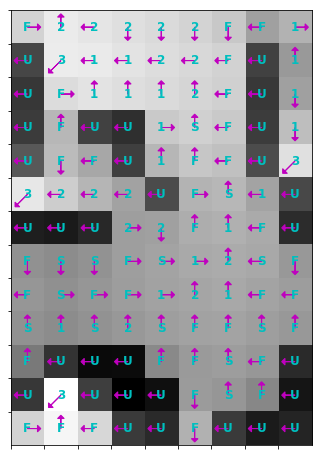

In [49]:
plot_values(mdp, Qi)

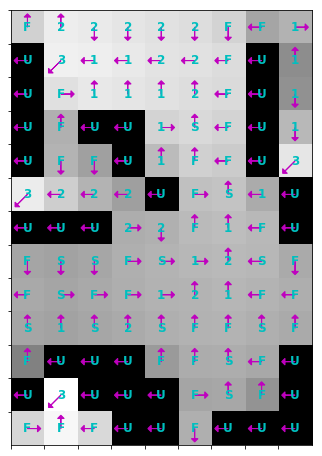

In [50]:
plot_values(mdp, exQs)

## SERD only

In [51]:
serd_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [52]:
Ts_thetas = T_estimate(adt_obs[train_demo_example_idxes]) #np.log(Tps2+.000000001)
feats = mdp.feature_map
Rs_thetas = np.random.normal(loc=1,scale=0.1,size=feats.shape[1])
Qs = None

In [53]:
maxiter = 500
t_learning_rate = lambda t: 0 if t<20 else 3 - (2 * int(t/(maxiter/2)))
r_learning_rate = lambda t: 2e-1 if t<20 else 1e-1

In [ ]:
while len(serd_train_logs['tt_lls']) < maxiter:
    prevQs = Qs.copy() if Qs is not None else None
    t = len(serd_train_logs['tt_lls'])
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    Rs = feats.dot(Rs_thetas)
    tp_ll, dT_pol, dR_pol, Qs = eval_TR_pol_likelihood_and_grad(Ts_thetas, Rs, feats, batch_demo_sas, Q_inits=Qs)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ts_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ts_thetas, Qs)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ts_thetas))
    Rs_thetas += r_learning_rate(t) * dR_pol
    Ts_thetas += t_learning_rate(t) * (dT_trans + dT_pol)

#     print(dT_trans)
#     print(dT_pol)
#     print(softmax(Ts_thetas))
#     print(dR_pol * r_learning_rate(t))
#     print(Rs_thetas)
#     if prevQs is not None:
#         print("Q_diff")
#         print(np.linalg.norm(Qs-prevQs))

    
    print('%d %f %f %f %f' % (t, vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    serd_train_logs['train_likelihoods'].append(train_likelihood)
    serd_train_logs['val_likelihoods'].append(val_likelihood)
    serd_train_logs['tp_lls'].append(tp_ll)
    serd_train_logs['tt_lls'].append(tt_ll)
    serd_train_logs['vp_lls'].append(vp_ll)
    serd_train_logs['vt_lls'].append(vt_ll)
    serd_train_logs['true_trans_loss'].append(ttd)

0 -373.042526 -98.882925 -471.925451 2.231689
1 -361.658886 -98.882925 -460.541812 2.231689
2 -351.052952 -98.882925 -449.935878 2.231689
3 -344.197507 -98.882925 -443.080432 2.231689
4 -336.607090 -98.882925 -435.490015 2.231689
5 -332.406944 -98.882925 -431.289869 2.231689
6 -325.768411 -98.882925 -424.651337 2.231689
7 -326.115046 -98.882925 -424.997971 2.231689
8 -323.557425 -98.882925 -422.440350 2.231689
9 -321.328051 -98.882925 -420.210976 2.231689
10 -320.186233 -98.882925 -419.069158 2.231689
11 -316.438068 -98.882925 -415.320994 2.231689
12 -317.395564 -98.882925 -416.278489 2.231689
13 -319.780494 -98.882925 -418.663420 2.231689
14 -316.005662 -98.882925 -414.888588 2.231689
15 -315.878766 -98.882925 -414.761691 2.231689
16 -309.912671 -98.882925 -408.795596 2.231689
17 -309.469986 -98.882925 -408.352911 2.231689
18 -309.707526 -98.882925 -408.590451 2.231689
19 -308.333035 -98.882925 -407.215960 2.231689
20 -307.231615 -98.882925 -406.114540 2.231689
21 -305.940754 -98.8558

In [ ]:
print(softmax(Ts_thetas))

In [ ]:
print(Rs_thetas)

In [ ]:
plt.plot(serd_train_logs['vp_lls'][:350])
plt.plot(idl_train_logs['vp_lls'][:350])

In [ ]:
plt.plot(serd_train_logs['vt_lls'][:350])
plt.plot(idl_train_logs['vt_lls'][:350])

In [ ]:
plt.plot(serd_train_logs['val_likelihoods'][:350], label = "SERD")
plt.plot(idl_train_logs['val_likelihoods'][:350], label = "IDL")
plt.title("Log likelihood of Demonstrations")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Log Likelihood")
plt.legend()

In [ ]:
plt.plot(serd_train_logs['true_trans_loss'][:350], label = "SERD")
plt.plot(idl_train_logs['true_trans_loss'][:350], label = "IDL")
plt.title("Square Error of Learned Transition Parameters")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Summed Square Error")
plt.legend()

## Comparison Tests

In [ ]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [ ]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs,temperature), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi,temperature), 2000, demo_time_steps)

In [ ]:
print(demo_stats(mdp, SERD_demos))

In [ ]:
print(demo_stats(mdp, IDL_demos))

In [ ]:
plot_values(mdp, Qs)

In [ ]:
plot_values(mdp, Qi)

In [ ]:
print(reward_map[5][0], Qi[2], Q[2])

### Transfer

In [ ]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

In [ ]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [ ]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit,temperature), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst,temperature), 1000, demo_time_steps)

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qit, temperature),Qs=Qit)

In [ ]:
print(demo_stats(mdp, IDL_trans_demos))

In [ ]:
print(demo_stats(mdp, SERD_trans_demos))

In [ ]:
plot_values(mdp, Qit)

In [ ]:
plot_values(mdp, Qst)

In [ ]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)